In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from ta import add_all_ta_features
from ta.trend import ema_indicator

In [2]:
data = yf.download('^RUA',start='1999-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,664.270020,672.929993,658.840027,663.159973,663.159973,0
1999-01-05,663.140015,671.219971,663.030029,670.849976,670.849976,0
1999-01-06,670.849976,684.940002,670.849976,684.820007,684.820007,0
1999-01-07,684.820007,684.820007,677.489990,683.919983,683.919983,0
1999-01-08,683.919983,689.150024,680.340027,687.109985,687.109985,0
...,...,...,...,...,...,...
2022-02-17,2608.429932,2608.429932,2547.719971,2550.969971,2550.969971,0
2022-02-18,2551.060059,2559.639893,2519.179932,2530.709961,2530.709961,0
2022-02-22,2529.739990,2538.919922,2483.409912,2503.709961,2503.709961,0


In [4]:
data = add_all_ta_features(data, open='Open', high='High', low='Low', close='Close', volume='Volume', fillna=True)
data['Return'] = data['Adj Close'].pct_change()
data['EMA100'] = ema_indicator(data.Close, window=100)
condition = [(data['Close'] > data['EMA100']) & (data['momentum_rsi'] > 50),
             (data['Close'] < data['EMA100']) & (data['momentum_rsi'] < 50)]
data['state'] = np.select(condition, [1,-1])
data = data.drop(columns='EMA100')
data = data.loc['2000-01-01':,:]

E:\Anaconda\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
E:\Anaconda\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [5]:
data['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 1    674
 0    171
-1    134
Name: state, dtype: int64

<AxesSubplot:xlabel='Date', ylabel='Close'>

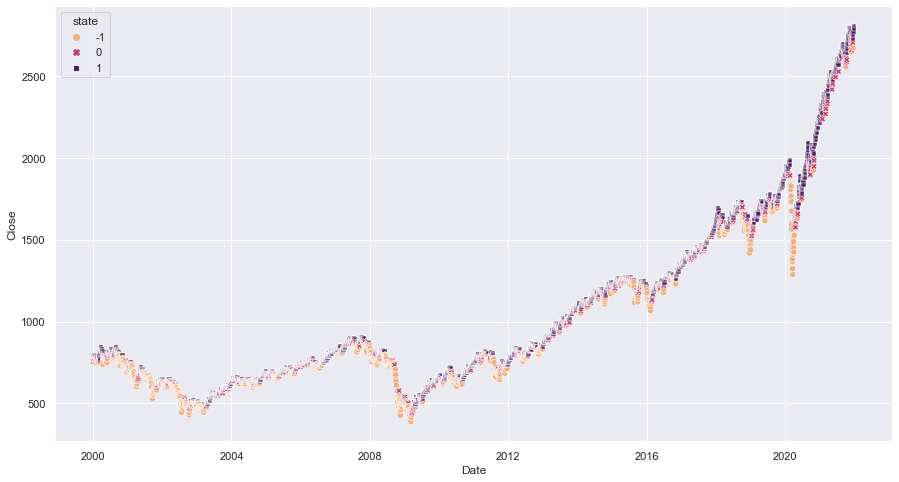

In [6]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(data=data.loc['2000-01-01':'2022-01-01',:], x='Date', y='Close', hue='state',style='state',palette='flare')

In [7]:
X_train, y_train = data.loc['2000-01-01':'2018-01-01',:].iloc[:,:-1], data.loc['2000-01-01':'2018-01-01',:].iloc[:,-1]
X_test, y_test = data.loc['2018-01-01':'2022-01-01',:].iloc[:,:-1], data.loc['2018-01-01':'2022-01-01',:].iloc[:,-1]

In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X_train, y_train)

In [9]:
model.score(X_test,y_test)

0.9417773237997957

In [10]:
model.score(X_test[:-1],y_test[1:])

0.8466257668711656

In [11]:
feature = pd.DataFrame(index=model.feature_names_in_, data=model.feature_importances_, columns=['feature'])
feature = feature.sort_values(by='feature', ascending=False)

In [12]:
feature.head(5)

,feature
momentum_rsi,0.132563
momentum_ppo,0.055918
momentum_tsi,0.050588
volatility_bbp,0.049083
trend_cci,0.046937


In [13]:
strategy = data.loc['2018-01-01':'2022-01-01',['Adj Close']]
strategy.insert(len(strategy.columns), 'State', '')
strategy.loc['2018-01-01':'2022-01-01',['State']] = model.predict(X_test)

In [14]:
strategy.insert(len(strategy.columns), 'Position Change', '')
strategy['Position Change'] = strategy['State'] - strategy['State'].shift(1)
strategy.iloc[0,-1] = strategy.iloc[0,1]
strategy.iloc[-1,-1] = -strategy.iloc[0,1]

In [15]:
strategy.insert(len(strategy.columns), 'Money', 0)
strategy['Money'] = -strategy['Adj Close'] * strategy['Position Change']

In [16]:
sum(strategy['Money'])

431.5391845703125

In [17]:
strategy['Position Change'].value_counts()

 0.0    846
-1.0     65
 1.0     55
 2.0      9
-2.0      4
Name: Position Change, dtype: int64

In [18]:
strategy

,Adj Close,State,Position Change,Money
Date,,,,
2018-01-02,1595.869995,1,1.0,-1595.869995
2018-01-03,1605.189941,1,0.0,-0.000000
2018-01-04,1611.020020,1,0.0,-0.000000
2018-01-05,1621.369995,1,0.0,-0.000000
2018-01-08,1624.349976,1,0.0,-0.000000
...,...,...,...,...
2021-12-27,2803.739990,1,0.0,-0.000000
2021-12-28,2798.350098,1,0.0,-0.000000
2021-12-29,2801.870117,1,0.0,-0.000000


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

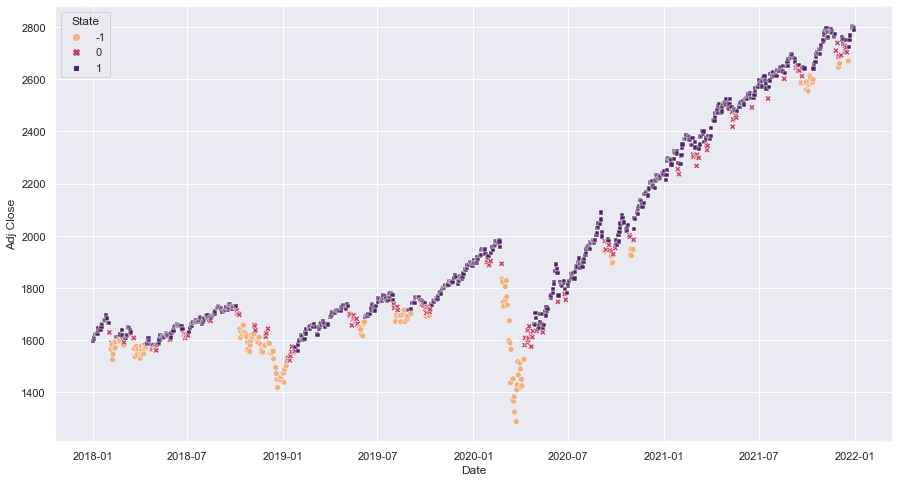

In [19]:
sns.scatterplot(data=strategy, x='Date', y='Adj Close', hue='State',style='State',palette='flare')

In [20]:
strategy2 = data.loc['2018-01-01':'2022-01-01',['Adj Close']]
strategy2.insert(len(strategy2.columns), 'State', '')
strategy2.loc['2018-01-01':'2022-01-01',['State']] = model.predict(X_test)

In [21]:
for i in range(5):
    strategy2[i]=strategy2['State'].shift(i)

In [22]:
strategy2.insert(len(strategy2.columns), 'New State', '')
for i in range(len(strategy2)):
    strategy2.iloc[i,-1] = int(strategy2.iloc[i,1:-1].mode().max())

In [24]:
strategy2.insert(len(strategy2.columns), 'Position Change', '')
strategy2['Position Change'] = strategy2['New State'] - strategy2['New State'].shift(1)
strategy2.iloc[0,-1] = strategy2.iloc[0,1]
strategy2.iloc[-1,-1] = -strategy2.iloc[-1,1]

In [25]:
strategy2.insert(len(strategy2.columns), 'Money', 0)
strategy2['Money'] = -strategy2['Adj Close'] * strategy2['Position Change']

In [26]:
sum(strategy2['Money'])

611.64013671875

In [27]:
def StateSmooth(data, n):
    X_train, y_train = data.loc['2000-01-01':'2018-01-01',:].iloc[:,:-1], data.loc['2000-01-01':'2018-01-01',:].iloc[:,-1]
    X_test, y_test = data.loc['2018-01-01':'2022-01-01',:].iloc[:,:-1], data.loc['2018-01-01':'2022-01-01',:].iloc[:,-1]
    model = RandomForestClassifier().fit(X_train, y_train)
    strategy = data.loc['2018-01-01':'2022-01-01',['Open','High','Low','Close','Adj Close']]
    strategy.insert(len(strategy.columns), 'State', '')
    strategy.loc['2018-01-01':'2022-01-01',['State']] = model.predict(X_test)
    for i in range(n):
        strategy[i]=strategy['State'].shift(i)
    strategy.insert(len(strategy.columns), 'New State', '')
    for i in range(len(strategy)):
        strategy.iloc[i,-1] = int(strategy.iloc[i,5:5+n+1].mode().max())
    strategy.insert(len(strategy.columns), 'Position Change', '')
    strategy['Position Change'] = strategy['New State'] - strategy['New State'].shift(1)
    strategy.iloc[0,-1] = strategy.iloc[0,5]
    strategy.iloc[-1,-1] = -strategy.iloc[-1,5]
    strategy.insert(len(strategy.columns), 'Money', 0)
    strategy['Money'] = -strategy['Adj Close'] * strategy['Position Change']
    return strategy

In [28]:
strategy1 = StateSmooth(data, 3)
strategy2 = StateSmooth(data, 5)
strategy3 = StateSmooth(data, 10)

In [29]:
strategy1.to_csv('C:/Users/lenovo/Downloads/strategy1.csv',columns=['Open', 'High', 'Low', 'Close','New State'])
strategy2.to_csv('C:/Users/lenovo/Downloads/strategy2.csv',columns=['Open', 'High', 'Low', 'Close','New State'])
strategy3.to_csv('C:/Users/lenovo/Downloads/strategy3.csv',columns=['Open', 'High', 'Low', 'Close','New State'])

In [30]:
sum(strategy1['Money'])

311.779541015625

In [31]:
sum(strategy2['Money'])

490.720458984375

In [32]:
sum(strategy3['Money'])

482.989990234375

In [33]:
data1 = pd.read_csv('d1.csv',index_col=0,parse_dates=True)
data2 = pd.read_csv('d2.csv',index_col=0,parse_dates=True)
data3 = pd.read_csv('d3.csv',index_col=0,parse_dates=True)
data4 = pd.read_csv('d4.csv',index_col=0,parse_dates=True)
data5 = pd.read_csv('d5.csv',index_col=0,parse_dates=True)

In [91]:
hmm1 = pd.read_csv('data_hmm_1_2003.csv',index_col=0,parse_dates=True)
hmm7 = pd.read_csv('data_hmm_7_revised_2003.csv',index_col=0,parse_dates=True)
gmm1 = pd.read_csv('data_gmm_1_2003.csv',index_col=0,parse_dates=True)

In [93]:
data6 = data1.copy()
data7 = data1.copy()
data8 = data1.copy()

In [94]:
data6['state'] = hmm1['State']
data7['state'] = hmm7['State']
data8['state'] = gmm1['State']

In [37]:
data1.insert(len(data1.columns), 'predict', '')
data2.insert(len(data2.columns), 'predict', '')
data3.insert(len(data3.columns), 'predict', '')
data4.insert(len(data4.columns), 'predict', '')
data5.insert(len(data5.columns), 'predict', '')

In [39]:
data1['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 0    966
-1      6
 1      6
Name: state, dtype: int64

In [40]:
data2['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 1    673
 0    171
-1    134
Name: state, dtype: int64

In [41]:
data3['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 0    937
-1     24
 1     17
Name: state, dtype: int64

In [42]:
data4['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 0    937
-1     24
 1     17
Name: state, dtype: int64

In [43]:
data5['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 0    871
-1     54
 1     53
Name: state, dtype: int64

In [95]:
data6['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 1.0    831
-1.0     98
 0.0     49
Name: state, dtype: int64

In [96]:
data7['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 1.0    734
-1.0    244
Name: state, dtype: int64

In [97]:
data8['state'].loc['2018-01-01':'2022-01-01'].value_counts()

 1.0    867
-1.0     73
 0.0     38
Name: state, dtype: int64

In [47]:
def randomforest(data):
    X_train, y_train = data.loc['2015-01-01':'2018-01-01',:].iloc[:,:-2], data.loc['2015-01-01':'2018-01-01',:].iloc[:,-2]
    X_test, y_test = data.loc['2018-01-01':'2022-01-01',:].iloc[:,:-2], data.loc['2018-01-01':'2022-01-01',:].iloc[:,-2]
    model = RandomForestClassifier().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.score(X_test, y_test), pd.DataFrame(y_pred)

In [48]:

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap=sns.diverging_palette(220, 20, n=7), ax=ax)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(['Bear','Static','Bull'])
    ax.set_yticklabels(['Bear','Static','Bull'])
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

In [49]:
score1, y_pred1 = randomforest(data1)
print(score1)
print(y_pred1.value_counts())
data1.loc['2018-01-01':'2022-01-01',['predict']] = y_pred1.to_numpy().reshape(-1,1)

0.9877300613496932
0    978
dtype: int64


In [50]:
score2, y_pred2 = randomforest(data2)
print(score2)
print(y_pred2.value_counts())
data2.loc['2018-01-01':'2022-01-01',['predict']] = y_pred2.to_numpy().reshape(-1,1)

0.8957055214723927
 1    722
 0    154
-1    102
dtype: int64


In [51]:
score3, y_pred3 = randomforest(data3)
print(score3)
print(y_pred3.value_counts())
data3.loc['2018-01-01':'2022-01-01',['predict']] = y_pred3.to_numpy().reshape(-1,1)

0.9815950920245399
 0    937
-1     29
 1     12
dtype: int64


In [52]:
score4, y_pred4 = randomforest(data4)
print(score4)
print(y_pred4.value_counts())
data4.loc['2018-01-01':'2022-01-01',['predict']] = y_pred4.to_numpy().reshape(-1,1)

0.9867075664621677
 0    940
-1     25
 1     13
dtype: int64


In [53]:
score5, y_pred5 = randomforest(data5)
print(score5)
print(y_pred5.value_counts())
data5.loc['2018-01-01':'2022-01-01',['predict']] = y_pred5.to_numpy().reshape(-1,1)

0.9519427402862985
 0    858
-1     67
 1     53
dtype: int64


In [98]:
score6, y_pred6 = randomforest(data6)
print(score6)
print(y_pred6.value_counts())
data6.loc['2018-01-01':'2022-01-01',['predict']] = y_pred6.to_numpy().reshape(-1,1)

0.8916155419222904
 1.0    866
-1.0     62
 0.0     50
dtype: int64


In [99]:
score7, y_pred7 = randomforest(data7)
print(score7)
print(y_pred7.value_counts())
data7.loc['2018-01-01':'2022-01-01',['predict']] = y_pred7.to_numpy().reshape(-1,1)

0.9611451942740287
 1.0    756
-1.0    222
dtype: int64


In [100]:
score8, y_pred8 = randomforest(data8)
print(score8)
print(y_pred8.value_counts())
data8.loc['2018-01-01':'2022-01-01',['predict']] = y_pred8.to_numpy().reshape(-1,1)

0.9703476482617587
 1.0    838
-1.0     84
 0.0     56
dtype: int64


In [57]:
data1.to_csv('C:/Users/lenovo/Downloads/data1.csv',columns=['Open', 'High', 'Low', 'Close','predict'])
data2.to_csv('C:/Users/lenovo/Downloads/data2.csv',columns=['Open', 'High', 'Low', 'Close','predict'])
data3.to_csv('C:/Users/lenovo/Downloads/data3.csv',columns=['Open', 'High', 'Low', 'Close','predict'])
data4.to_csv('C:/Users/lenovo/Downloads/data4.csv',columns=['Open', 'High', 'Low', 'Close','predict'])
data5.to_csv('C:/Users/lenovo/Downloads/data5.csv',columns=['Open', 'High', 'Low', 'Close','predict'])

In [101]:
data6.to_csv('C:/Users/lenovo/Downloads/data6.csv',columns=['Open', 'High', 'Low', 'Close','predict'])
data7.to_csv('C:/Users/lenovo/Downloads/data7.csv',columns=['Open', 'High', 'Low', 'Close','predict'])
data8.to_csv('C:/Users/lenovo/Downloads/data8.csv',columns=['Open', 'High', 'Low', 'Close','predict'])

In [59]:
from hmmlearn import hmm

In [60]:
X_train_hmm, X_test_hmm = data['Return'].loc['2000-01-01':'2017-12-31'], data['Return'].loc['2018-01-01':'2021-12-31']

In [61]:
model_hmm = hmm.GaussianHMM(n_components=3).fit(X_train_hmm.to_numpy().reshape(-1,1))

In [62]:
data_hmm = data.copy()
data_hmm.insert(len(data.columns), 'predict', '')

In [63]:
data_hmm.loc['2000-01-01':'2017-12-31',['predict']] = model_hmm.predict(X_train_hmm.to_numpy().reshape(-1,1))
data_hmm.loc['2018-01-01':'2021-12-31',['predict']] = model_hmm.predict(X_test_hmm.to_numpy().reshape(-1,1))

In [64]:
data_hmm['predict'].loc['2018-01-01':'2021-12-31'].value_counts()
data_hmm.loc[data_hmm['predict']==1, 'predict']=-1
data_hmm.loc[data_hmm['predict']==2, 'predict']=1

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

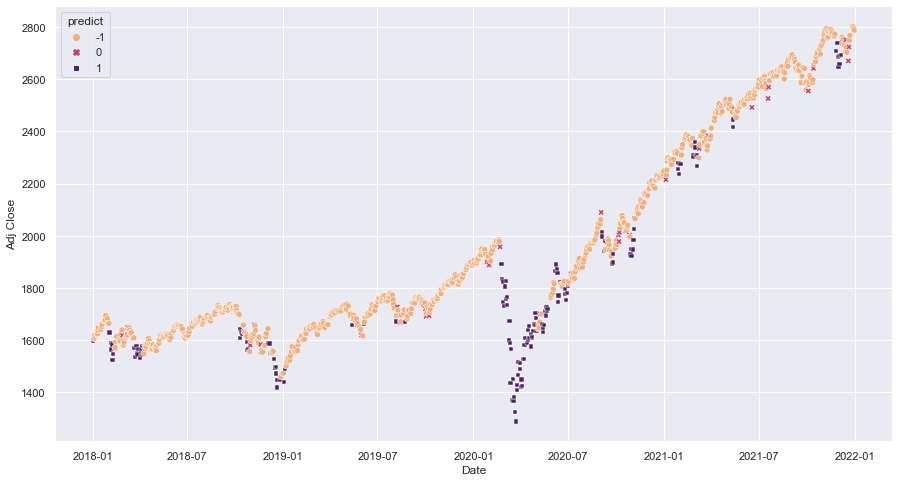

In [65]:
sns.scatterplot(data=data_hmm.loc['2018-01-01':'2021-12-31',:], x='Date', y='Adj Close', hue='predict', style='predict', palette='flare')

In [66]:
data_hmm['predict'].loc['2018-01-01':'2021-12-31'].value_counts()

-1    773
 1    153
 0     53
Name: predict, dtype: int64

In [67]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [68]:
data_lstm = data.loc[:,['Adj Close','Return','volatility_dcp','trend_macd','momentum_rsi','state']].copy()

In [69]:
data_lstm

,Adj Close,Return,volatility_dcp,trend_macd,momentum_rsi,state
Date,,,,,,
2000-01-03,786.200012,-0.008962,0.746316,11.071727,64.679734,1
2000-01-04,755.799988,-0.038667,0.115217,8.251234,42.517744,0
2000-01-05,757.090027,0.001707,0.256655,6.050324,43.403961,0
2000-01-06,756.729980,-0.000476,0.250179,4.228293,43.203759,0
2000-01-07,777.250000,0.027117,0.619245,4.389515,55.735207,1
...,...,...,...,...,...,...
2022-02-17,2550.969971,-0.022325,0.443353,-23.528127,40.740828,-1
2022-02-18,2530.709961,-0.007942,0.352088,-27.206752,38.746777,-1
2022-02-22,2503.709961,-0.010669,0.106211,-31.932664,36.203651,-1


In [70]:
from sklearn.preprocessing import StandardScaler
data_lstm.iloc[:,:-1] = StandardScaler().fit_transform(data_lstm.iloc[:,:-1])

In [71]:
data_lstm

,Adj Close,Return,volatility_dcp,trend_macd,momentum_rsi,state
Date,,,,,,
2000-01-03,-0.487103,-0.734459,0.391041,0.664012,0.970446,1
2000-01-04,-0.544506,-3.093308,-1.644314,0.449276,-1.004414,0
2000-01-05,-0.542070,0.112792,-1.188161,0.281711,-0.925443,0
2000-01-06,-0.542750,-0.060515,-1.209046,0.142992,-0.943283,0
2000-01-07,-0.504003,2.130593,-0.018775,0.155267,0.173397,1
...,...,...,...,...,...,...
2022-02-17,2.845200,-1.795558,-0.586043,-1.970224,-1.162756,-1
2022-02-18,2.806945,-0.653432,-0.880382,-2.250293,-1.340446,-1
2022-02-22,2.755962,-0.869973,-1.673359,-2.610097,-1.567065,-1


In [72]:
X_train_lstm, X_test_lstm = data_lstm.loc['2000-01-01':'2017-12-31'].iloc[:,:-1], data_lstm.loc['2018-01-01':'2021-12-31'].iloc[:,:-1]
y_train_lstm, y_test_lstm = data_lstm.loc['2000-01-01':'2017-12-31'].iloc[:,-1], data_lstm.loc['2018-01-01':'2021-12-31'].iloc[:,-1]